In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import CIFAR10_utils as utils

# Tune hyperparameters

In [3]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
count = -1
for lr_0, n, random_state, weight_decay in itertools.product(lr_0s, ns, random_states, weight_decays):
    count += 1
    model_name = 'nonlearned_lr_0={}_n={}_random_state={}_weight_decay={}'\
    .format(lr_0, n, random_state, weight_decay)
    print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --random_state={} --tune --wandb --weight_decay={}"'\
          .format(dataset_path, experiments_path, lr_0, model_name, n, prior_path, random_state, weight_decay))
print(count)

    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10' --lr_0=0.1 --model_name='nonlearned_lr_0=0.1_n=10_random_state=1001_weight_decay=0.01' --n=10 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --random_state=1001 --tune --wandb --weight_decay=0.01"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10' --lr_0=0.1 --model_name='nonlearned_lr_0=0.1_n=10_random_state=1001_weight_decay=0.001' --n=10 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --random_state=1001 --tune --wandb --weight_decay=0.001"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-le

In [34]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10000]
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
prior_scales = np.logspace(0, 9, num=10)
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
count = -1
for lr_0, n, prior_scale, random_state, weight_decay in itertools.product(lr_0s, ns, prior_scales, random_states, weight_decays):
    count += 1
    model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
    .format(lr_0, n, prior_scale, random_state, weight_decay)
    print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --learned_prior --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_scale={} --random_state={} --tune --wandb --weight_decay={}"'\
          .format(dataset_path, experiments_path, lr_0, model_name, n, prior_path, prior_scale, random_state, weight_decay))
print(count)

    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10' --learned_prior --lr_0=0.1 --model_name='learned_lr_0=0.1_n=10000_prior_scale=1.0_random_state=1001_weight_decay=0.01' --n=10000 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --prior_scale=1.0 --random_state=1001 --tune --wandb --weight_decay=0.01"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10' --learned_prior --lr_0=0.1 --model_name='learned_lr_0=0.1_n=10000_prior_scale=1.0_random_state=1001_weight_decay=0.001' --n=10000 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --prior_scale=1.0 --random_state=1001 --tune --wandb --weight_decay=0.001"
    "python ../src/CIFAR10_main.py --dataset_path='/cluste

# Retrain with selected parameters

In [19]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_val_loss(df):
    return df.val_or_test_loss.values[-1]

def get_val_acc(df):
    return df.val_or_test_acc.values[-1]

def get_last_epoch(df):
    return df.iloc[-1]

def get_nonlearned_hyperparameters(experiments_path, lr_0s, ns, random_states, weight_decays):
    columns = ['lr_0', 'n', 'random_state', 'weight_decay']
    df = pd.DataFrame(columns=columns)
    for n, random_state in itertools.product(ns, random_states):
        best_val_loss = np.inf
        best_hyperparameters = None
        for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
            model_name = 'nonlearned_lr_0={}_n={}_random_state={}_weight_decay={}'\
            .format(lr_0, n, random_state, weight_decay)
            path =  '{}/{}.csv'.format(experiments_path, model_name)
            val_loss = get_val_loss(get_df(path))
            if val_loss < best_val_loss: best_val_loss = val_loss; best_hyperparameters = [lr_0, n, random_state, weight_decay]
        df.loc[df.shape[0]] = best_hyperparameters
    return df

def get_learned_hyperparameters(experiments_path, lr_0s, ns, prior_scales, random_states, weight_decays):
    columns = ['lr_0', 'n', 'prior_scale', 'random_state', 'val_acc', 'weight_decay']
    df = pd.DataFrame(columns=columns)
    for n, prior_scale, random_state in itertools.product(ns, prior_scales, random_states):
        best_val_loss = np.inf
        best_hyperparameters = None
        for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
            model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
            .format(lr_0, n, prior_scale, random_state, weight_decay)
            path =  '{}/{}.csv'.format(experiments_path, model_name)
            val_loss = get_val_loss(get_df(path))
            val_acc = get_val_acc(get_df(path))
            if val_loss < best_val_loss: best_val_loss = val_loss; best_hyperparameters = [lr_0, n, prior_scale, random_state, val_acc, weight_decay]
        df.loc[df.shape[0]] = best_hyperparameters
    return df

In [20]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
df = get_nonlearned_hyperparameters(experiments_path, lr_0s, ns, random_states, weight_decays)
df

,lr_0,n,random_state,weight_decay
0,0.0001,10.0,1001.0,0.00010
1,0.0100,10.0,2001.0,0.00100
2,0.0010,10.0,3001.0,0.01000
3,0.0001,100.0,1001.0,0.00001
4,0.0001,100.0,2001.0,0.00010
5,0.0001,100.0,3001.0,0.00100
6,0.0100,1000.0,1001.0,0.00100
7,0.0100,1000.0,2001.0,0.00100
8,0.0100,1000.0,3001.0,0.00001
9,0.0100,10000.0,1001.0,0.00100


In [21]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
count = -1
for row_index, row in df.iterrows():
    count += 1
    model_name = 'nonlearned_lr_0={}_n={}_random_state={}_weight_decay={}'\
    .format(row.lr_0, int(row.n), int(row.random_state), row.weight_decay)
    print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --random_state={} --wandb --weight_decay={}"'\
          .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, int(row.random_state), row.weight_decay))
print(count)

    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10' --lr_0=0.0001 --model_name='nonlearned_lr_0=0.0001_n=10_random_state=1001_weight_decay=0.0001' --n=10 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --random_state=1001 --wandb --weight_decay=0.0001"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10' --lr_0=0.01 --model_name='nonlearned_lr_0=0.01_n=10_random_state=2001_weight_decay=0.001' --n=10 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --random_state=2001 --wandb --weight_decay=0.001"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-trans

In [30]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [1000]
prior_scales = np.logspace(0, 9, num=10)
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
df = get_learned_hyperparameters(experiments_path, lr_0s, ns, prior_scales, random_states, weight_decays)
df

,lr_0,n,prior_scale,random_state,val_acc,weight_decay
0,0.0100,1000.0,1.000000e+00,1001.0,0.839728,0.000001
1,0.0100,1000.0,1.000000e+00,2001.0,0.831408,0.000010
2,0.0100,1000.0,1.000000e+00,3001.0,0.833438,0.000010
3,0.0100,1000.0,1.000000e+01,1001.0,0.853189,0.000010
4,0.0100,1000.0,1.000000e+01,2001.0,0.802901,0.000010
5,0.0100,1000.0,1.000000e+01,3001.0,0.825037,0.000010
6,0.0100,1000.0,1.000000e+02,1001.0,0.840746,0.000001
7,0.0100,1000.0,1.000000e+02,2001.0,0.831017,0.000010
8,0.0100,1000.0,1.000000e+02,3001.0,0.823616,0.000001
9,0.0100,1000.0,1.000000e+03,1001.0,0.840366,0.000010


In [31]:
# TODO: If more seeds are added average over seeds
grouped_df = df.groupby(['n', 'prior_scale']).agg(lambda x: tuple(x))
columns = ['val_acc']
for column in columns:
    grouped_df['{}_mean'.format(column)] = grouped_df[column].apply(lambda item: np.mean(item))
    grouped_df['{}_std'.format(column)] = grouped_df[column].apply(lambda item: np.std(item))
grouped_df = grouped_df.reset_index()

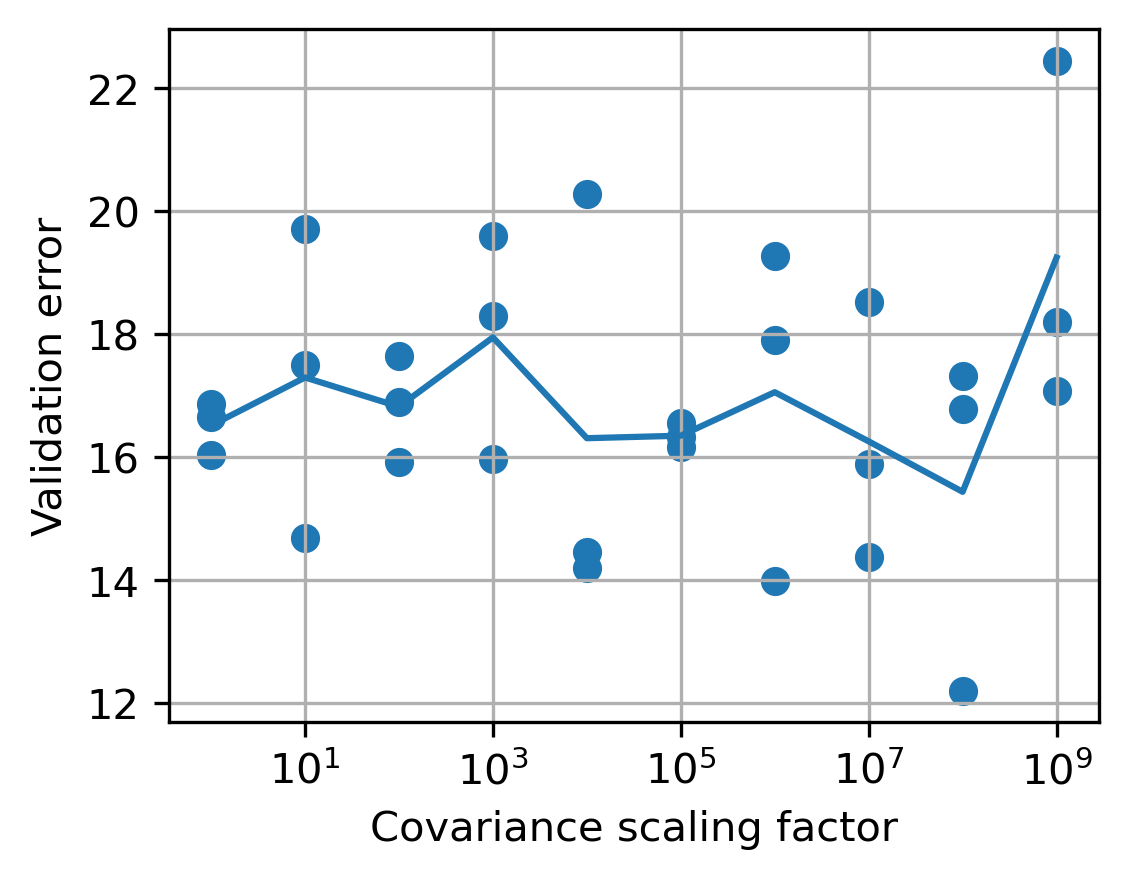

In [33]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=300)
ax.scatter(df.prior_scale, 100*(1-df.val_acc))
ax.plot(grouped_df.prior_scale, 100*(1-grouped_df.val_acc_mean))
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('Validation error')
ax.grid()
plt.show()

In [16]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
count = -1
for row_index, row in df.iterrows():
    model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
    .format(row.lr_0, int(row.n), row.prior_scale, int(row.random_state), row.weight_decay)
    if not os.path.exists('{}/{}.csv'.format(experiments_path, model_name)):
        count += 1
        print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --learned_prior --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_scale={} --random_state={} --wandb --weight_decay={}"'\
              .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, row.prior_scale, int(row.random_state), row.weight_decay))
print(count)

-1
